# Coastal Change

*****
### This Notebook:  

- Highlights a simple method for detecting coastal change between two timeframes
- Visualizes water classification for two timeframes
- Visualizes water classification changes between timeframes
------  
### Motivation:  

International agencies like World Bank, UNEP, and USAID are currently reporting and addressing the problem of coastal erosion near Lomé, Togo.  The links listed below are references from these agencies regarding coastal erosion in Togo and coastal erosion as a world wide phenomena.  

- *"West Africa Coastal Erosion Project launched in Togo" (2016) *  [- link](http://www.ndf.fi/news/west-africa-coastal-erosion-project-launched-togo)
- *Agreement to Erosion Adaptation Project* (2016)  [- link](http://pubdocs.worldbank.org/en/493191479316551864/WACA-Lom%C3%A9-Communiqu%C3%A9-2016-English.pdf)
- World Bank WACA program brochure (2015)  [- link](http://pubdocs.worldbank.org/en/622041448394069174/1606426-WACA-Brochure.pdf)
- UNEP - Technologies for climate change adaption (2010)  [- link](http://www.unep.org/pdf/TNAhandbook_CoastalErosionFlooding.pdf)  
- USAID - Adapting to Coastal Climate Change (2009) -  [- link](http://www.crc.uri.edu/download/CoastalAdaptationGuide.pdf)  
- UNEP - Coastal Erosion and Climate Change in Western Africa(2002) -  [- link](http://www.unep.org/dewa/africa/publications/aeo-1/121.htm)
  
-------
### Algorithmic Profile:  
  
- This algorithm generates a water change product.
- The product is derived from Landsat7 Collection 1, Tier 2 sr imagery taken from USGS data holdings.    
- Utilizes WOFS for water detection.
-------  
### Process:  

- Load in a year's worth of data for years `y1` and `y2`, 
- Reduce noise by temporal compositing of both `y1` and `y2` to yield `y1_composite` and `y2_composite` .(This removes clouds, scanline errors, and statistical anomalies)      
- Run WOFS water classifier on `y1_composite` and `y2_composite`, to yield `y1_water` and `y2_water`. These outputs contain a 1 for water, and 0 for not water.     
- Subtract `y1_water` from `y2_water` to yield a `coastal_change` product. Where 0 represents no change, 1 represents water gain, and -1 represents water loss. 
*****  

> **Flow Diagram**
![](diagrams/rainy_demo/algo_nb3.png)

In [1]:
%matplotlib inline

from datetime import datetime
import numpy as np

import datacube
import utils.data_cube_utilities.dc_utilities as utils

from utils.data_cube_utilities.dc_mosaic import create_mosaic, ls8_unpack_qa
from utils.data_cube_utilities.dc_water_classifier import wofs_classify

# import warnings; warnings.simplefilter('ignore')

In [2]:
start_time = datetime.now()
print("Start time: " + str(start_time))

Start time: 2020-05-21 16:26:29.132147


In [3]:
# Initialize data cube object
dc = datacube.Datacube(app='dc-coastal-erosion')

# Set query parameters
platform        = 'LANDSAT_8'
product_type    = 'ls8_usgs_sr_scene'

# Select minimum and maximum longitudes and latitudes.

# Ghana
# Coastline east of Accra
lon = (0.0520, 0.3458)
lat = (5.6581, 5.8113)

In [4]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(lat, lon)

In [5]:
first_year = 2013
first_time_range = (f'{first_year}-01-01', f'{first_year}-12-31')

In [6]:
measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']
# Retrieve data from Data Cube
first_dataset = dc.load(platform=platform,
                           product=product_type,
                           time=first_time_range,
                           lon=lon, lat=lat, measurements=measurements)

In [7]:
# Time range after `first_time_range`.
last_year = 2014
second_time_range = (f'{last_year}-01-01', f'{last_year}-12-31')

In [8]:
# Retrieve data from Data Cube
second_dataset = dc.load(platform=platform,
                           product=product_type,
                           time=second_time_range,
                           lon=lon, lat=lat, measurements=measurements)

In [9]:
# Only keep pixels that are clear or have water.
clear_xarray  = ls8_unpack_qa(first_dataset.pixel_qa, "clear")  
water_xarray  = ls8_unpack_qa(first_dataset.pixel_qa, "water")
first_clean_mask = np.logical_or(clear_xarray.values.astype(bool),
                                 water_xarray.values.astype(bool))

clear_xarray  = ls8_unpack_qa(second_dataset.pixel_qa, "clear")  
water_xarray  = ls8_unpack_qa(second_dataset.pixel_qa, "water")
second_clean_mask = np.logical_or(clear_xarray.values.astype(bool),
                                  water_xarray.values.astype(bool))

# Remove noise from images by using appropriate data within the dataset to replace "dirty" data.
first_mosaic = create_mosaic(first_dataset, clean_mask=first_clean_mask)
second_mosaic = create_mosaic(second_dataset, clean_mask=second_clean_mask)

In [10]:
first_water_class = wofs_classify(first_mosaic, mosaic=True, no_data=np.nan)
second_water_class = wofs_classify(second_mosaic, mosaic=True, no_data=np.nan)

first_wofs = first_water_class.wofs.values
second_wofs = second_water_class.wofs.values

In [11]:
coastal_change = second_water_class - first_water_class

In [12]:
import matplotlib.pyplot as plt 
def plot_data_array_with_aspect(da):
    fig, ax = plt.subplots(figsize=(15,8))
    ax.set_aspect('equal')
    da.plot()

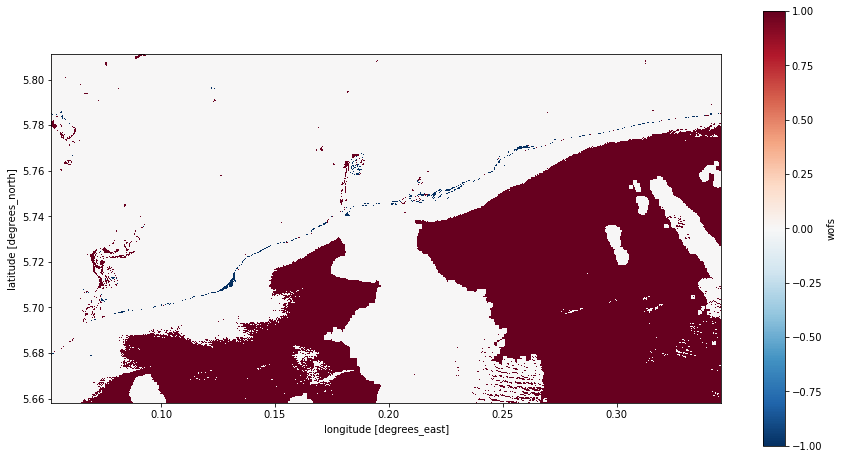

In [13]:
# -1 -> water to coast
#  0 -> no change
#  1 -> coast to water (Coastal Erosion)

plot_data_array_with_aspect( coastal_change.wofs )

In [14]:
first_coastline = np.zeros(first_wofs.shape)

for i in range(first_wofs.shape[0]):
    for j in range(first_wofs.shape[1]):
        pixel = first_wofs[i,j]
        if pixel == 0 and np.nansum(first_wofs[i-1:i+2, j-1:j+2]) >= 1 and np.nansum(first_wofs[i-1:i+2, j-1:j+2]) <= 5:
            first_wofs[i,j] = 1
            
second_coastline = np.zeros(second_wofs.shape)

for i in range(second_wofs.shape[0]):
    for j in range(second_wofs.shape[1]):
        pixel = second_wofs[i,j]
        if pixel == 0 and np.nansum(second_wofs[i-1:i+2, j-1:j+2]) >= 1 and np.nansum(second_wofs[i-1:i+2, j-1:j+2]) <= 5:
            second_wofs[i,j] = 1

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [16]:
from pylab import imshow

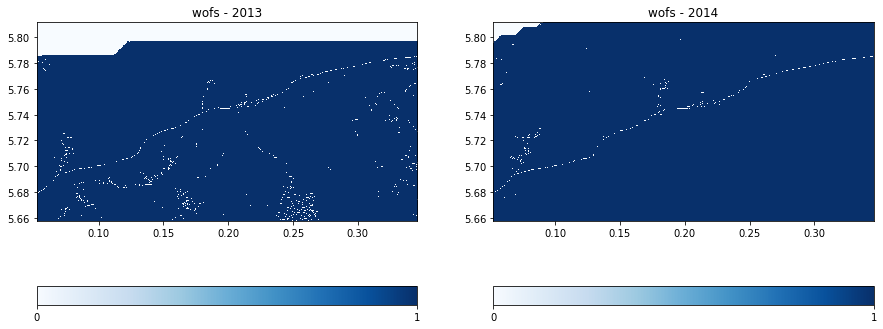

In [17]:
fig = plt.figure(figsize =  (15,8))
a=fig.add_subplot(1,2,1) 

imgplot = plt.imshow(first_wofs, cmap='Blues',
                     extent=[first_water_class.longitude.values.min(), 
                             first_water_class.longitude.values.max(),
                             first_water_class.latitude.values.min(),
                             first_water_class.latitude.values.max()])
a.set_title(f'wofs - {first_year}')
plt.colorbar(ticks=[0,1], orientation ='horizontal')
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(second_wofs, cmap='Blues',
                     extent=[second_water_class.longitude.values.min(), 
                             second_water_class.longitude.values.max(),
                             second_water_class.latitude.values.min(),
                             second_water_class.latitude.values.max()])
#imgplot.set_clim(0.0,1.0)
a.set_title(f'wofs - {last_year}')
plt.colorbar(ticks=[0,1], orientation='horizontal')
plt.savefig('wofs_compare.png')

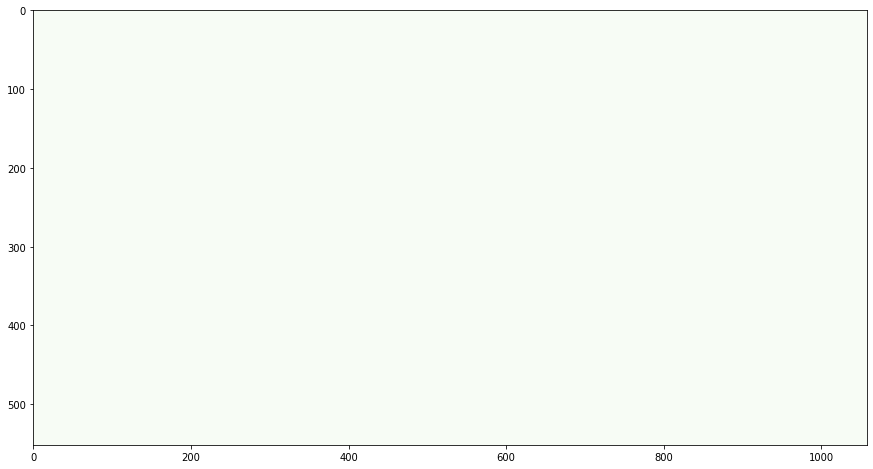

In [18]:
fig = plt.figure(figsize =  (15,8))
plt.imshow(first_coastline, cmap='Greens')

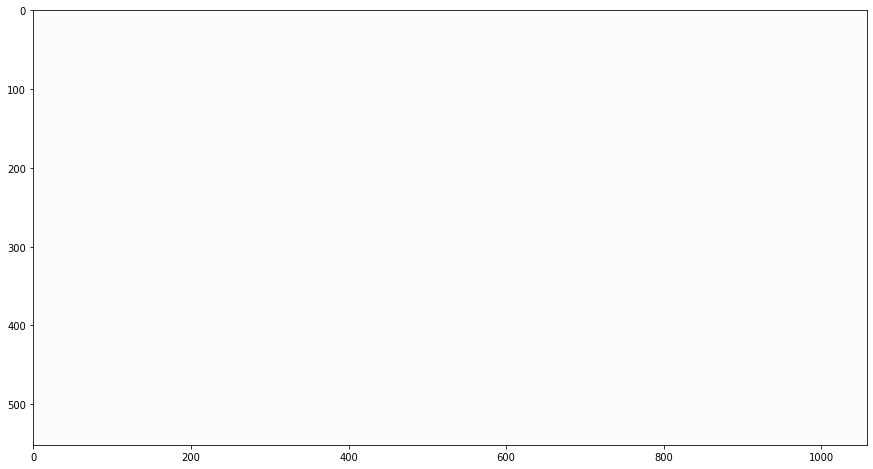

In [19]:
fig = plt.figure(figsize =  (15,8))
plt.imshow(second_coastline, cmap='Purples')

In [20]:
first_mosaic

<xarray.Dataset>
Dimensions:    (latitude: 552, longitude: 1058)
Coordinates:
  * latitude   (latitude) float64 5.811 5.811 5.811 5.81 ... 5.659 5.658 5.658
  * longitude  (longitude) float64 0.05208 0.05236 0.05264 ... 0.3454 0.3457
Data variables:
    red        (latitude, longitude) int16 835 1009 962 952 ... 381 419 413 467
    green      (latitude, longitude) int16 694 808 778 770 ... 439 471 454 512
    blue       (latitude, longitude) int16 384 396 388 394 ... 442 474 464 510
    nir        (latitude, longitude) int16 1524 1604 1569 1472 ... 458 451 493
    swir1      (latitude, longitude) int16 2096 2133 2035 2002 ... 470 454 499
    swir2      (latitude, longitude) int16 1546 1654 1579 1583 ... 388 381 413
    pixel_qa   (latitude, longitude) uint16 55537 322 322 322 ... 324 324 324

In [21]:
first_mosaic_rgb = np.array([first_mosaic.red.values, first_mosaic.green.values, first_mosaic.blue.values])

In [22]:
first_mosaic_rgb

array([[[ 835, 1009,  962, ..., 1483, 2272, 3331],
        [1086, 1039,  958, ..., 1538, 2681, 3388],
        [1088,  982,  962, ..., 1610, 2859, 3356],
        ...,
        [ 346,  358,  355, ...,  380,  400,  385],
        [ 351,  347,  344, ...,  392,  408,  416],
        [ 350,  348,  351, ...,  419,  413,  467]],

       [[ 694,  808,  778, ..., 1267, 1919, 2997],
        [ 862,  827,  766, ..., 1319, 2339, 3110],
        [ 861,  792,  776, ..., 1344, 2475, 3089],
        ...,
        [ 527,  540,  540, ...,  428,  444,  432],
        [ 537,  532,  536, ...,  445,  473,  472],
        [ 542,  536,  537, ...,  471,  454,  512]],

       [[ 384,  396,  388, ...,  947, 1505, 2326],
        [ 446,  417,  393, ...,  992, 1869, 2444],
        [ 450,  405,  399, ..., 1006, 1932, 2423],
        ...,
        [ 394,  406,  407, ...,  436,  453,  446],
        [ 398,  398,  399, ...,  442,  477,  470],
        [ 402,  396,  399, ...,  474,  464,  510]]], dtype=int16)